<a href="https://colab.research.google.com/github/sio-co2o2/scrippsco2_notebooks/blob/main/notebooks/plot_full_mlo_record_color_scrippsco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/sio-co2o2/scrippsco2_notebooks/main?labpath=notebooks%2Fplot_full_mlo_record_color_scrippsco2.ipynb)

# Plot full CO2 record at Mauna Loa, Hawaii with gradient

### Scripps CO2 Program
https://scrippsco2.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [1]:
import re
import pandas as pd
import numpy as np
from scipy import interpolate
import scipy.optimize as spopt
import math
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import os
from PIL import Image

%matplotlib inline

In [ ]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg
  from cairosvg import svg2png

In [ ]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

## Set directories and file names for data,  plot, and logo

In [2]:
# Data from scrippsco2.ucsd.edu
insitu_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly'

# Data from bluemoon
#insitu_data_dir = 'data/to_post/in_situ_co2/monthly'

monthly_mlo_file = 'monthly_in_situ_co2_mlo.csv'
data_url = f"{insitu_data_dir}/{monthly_mlo_file}" 

# Set plot directories for website graphics gallery
plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_pdf_dir = pathlib.Path(plot_dir / 'pdf')
plot_pdf_dir.mkdir(exist_ok=True)

plot_png_dir = pathlib.Path(plot_dir / 'png')
plot_png_dir.mkdir(exist_ok=True)

plot_display_dir = pathlib.Path(plot_dir / 'display')
plot_display_dir.mkdir(exist_ok=True)

plot_thumbnail_dir = pathlib.Path(plot_dir / 'thumbnails')
plot_thumbnail_dir.mkdir(exist_ok=True)

# logo_file = 'images/ucsd_sio_logo.svg'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/logos/ucsd_sio_logo.svg'

plot_name = 'mlo_color_plot'

pdf_file = plot_pdf_dir / f'{plot_name}.pdf'
png_file = plot_png_dir / f'{plot_name}.png'
png_display_file = plot_display_dir / f'{plot_name}.png'
png_thumbnail_file = plot_thumbnail_dir / f'{plot_name}.png'


## Load in Data and process

### Look at the file comments to see what the columns represent

In [3]:
# Fetch with URL
response = requests.get(data_url)
file_text = response.text
text_lines = file_text.split('\n')

# Fetch with file
# with open(data_url) as f:
#     text_lines = f.readlines()

# From looking at the file, the column description comments start with
# the words 'The data file below'
comments = [line for line in text_lines if line.startswith('"')]

search_str = 'The data file below'
desc_line_start = [index for index, comment in enumerate(comments) if search_str in comment]

if desc_line_start:
    col_desc = comments[desc_line_start[0]:]
    print(''.join(col_desc))

" The data file below contains 10 columns.  Columns 1-4 give the dates in several redundant "" formats. Column 5 below gives monthly Mauna Loa CO2 concentrations in micro-mol CO2 per   "" mole (ppm), reported on the 2012 SIO manometric mole fraction scale.  This is the        "" standard version of the data most often sought.  The monthly values have been adjusted    "" to 24:00 hours on the 15th of each month.  Column 6 gives the same data after a seasonal  "" adjustment to remove the quasi-regular seasonal cycle.  The adjustment involves           "" subtracting from the data a 4-harmonic fit with a linear gain factor.  Column 7 is a      "" smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic "" functions with linear gain.  Column 8 is the same smoothed version with the seasonal      "" cycle removed.  Column 9 is identical to Column 5 except that the missing values from     "" Column 5 have been filled with values from Column 7.  Column 10 is id

### Load in data

In [4]:
df = pd.read_csv(data_url,skipinitialspace=True,comment='"')
df.head()

,Yr,Mn,Date,Date.1,CO2,seasonally,fit,seasonally.1,CO2.1,seasonally.2,Sta
0,NaN,NaN,NaN,NaN,NaN,adjusted,NaN,adjusted fit,filled,adjusted filled,NaN
1,NaN,NaN,Excel,NaN,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958.0,1.0,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958.0,2.0,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958.0,3.0,21259,1958.2027,315.71,314.43,316.20,314.90,315.71,314.43,MLO


### To plot, want the decimal date (col 4) along with CO2 (col 5) and CO2 fit (col 7)
Due to the column headers spread over 3 lines and the top line repeating col names, pandas denotes the identical string with a subscript.

### Rename columns for Pandas and the user

In [5]:
col_mapping ={df.columns[0]:'year', df.columns[1]: 'month', df.columns[2]: 'excel_date', 
              df.columns[3]: 'dec_date', df.columns[4]: 'co2', df.columns[5]: 'co2_seasonal',
              df.columns[6]: 'co2_fit', df.columns[7]: 'co2_seasonal_fit', 
              df.columns[8]:'co2_filled', df.columns[9]: 'co2_seasonal_filled',
              df.columns[10]: 'Sta'}
df = df.rename(columns=col_mapping)
df.head()

,year,month,excel_date,dec_date,co2,co2_seasonal,co2_fit,co2_seasonal_fit,co2_filled,co2_seasonal_filled,Sta
0,NaN,NaN,NaN,NaN,NaN,adjusted,NaN,adjusted fit,filled,adjusted filled,NaN
1,NaN,NaN,Excel,NaN,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958.0,1.0,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958.0,2.0,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958.0,3.0,21259,1958.2027,315.71,314.43,316.20,314.90,315.71,314.43,MLO


### Remove the first two column descriptor lines

In [6]:
df = df.iloc[2:]


### Break into dataframes for MLO and MKO stations


In [7]:
df_mlo_subset = df[df['Sta'] == 'MLO']

df_mlo = df_mlo_subset[['dec_date', 'co2']].copy()
df_mlo_spline = df_mlo_subset[['dec_date', 'co2_fit']].copy()

df_mko_subset = df[df['Sta'] == 'MKO']

df_mko = df_mko_subset[['dec_date', 'co2']].copy()
df_mko_spline = df_mko_subset[['dec_date', 'co2_fit']].copy()

### Convert columns into decimals

This is because there were string values in the columns when they were initially read into the dataframe

In [8]:
df_mlo = df_mlo.apply(pd.to_numeric)
df_mlo_spline = df_mlo_spline.apply(pd.to_numeric)

df_mko = df_mko.apply(pd.to_numeric)
df_mko_spline = df_mko_spline.apply(pd.to_numeric)


### Remove rows with fill values -99.99 or NaN

In [9]:
df_mlo = df_mlo[df_mlo['co2'] != -99.99]
df_mlo_spline = df_mlo_spline[df_mlo_spline['co2_fit'] != -99.99]

df_mlo = df_mlo.dropna()
df_mlo_spline = df_mlo_spline.dropna()

df_mko = df_mko[df_mko['co2'] != -99.99]
df_mko_spline = df_mko_spline[df_mko_spline['co2_fit'] != -99.99]

df_mko = df_mko.dropna()
df_mko_spline = df_mko_spline.dropna()

### Get dates when MKO data used

Will use these date boundaries when plotting MLO to not plot a fit line through the data when there is a gap

In [10]:
# Hardcode in the MKO dates to plot that are in the MLO gap

#Do this until I write code about finding gaps

mko_decimal_start_date = 2022.9562 # Dec
mko_decimal_end_date = 2023.126 # Feb

### Convert to numpy arrays for plotting

In [11]:
date_mlo = df_mlo['dec_date'].to_numpy()
co2_mlo = df_mlo['co2'].to_numpy()

date_spline_mlo = df_mlo_spline['dec_date'].to_numpy()
co2_spline_mlo = df_mlo_spline['co2_fit'].to_numpy()

date_mko = df_mko['dec_date'].to_numpy()
co2_mko = df_mko['co2'].to_numpy()

date_spline_mko = df_mko_spline['dec_date'].to_numpy()
co2_spline_mko = df_mko_spline['co2_fit'].to_numpy()

### For color plot, combine MLO & MKO data as one set

In [12]:
# Concat MLO & MKO date and co2, then put in df and sort
date_all= np.concatenate((date_mlo, date_mko))
co2_all = np.concatenate((co2_mlo, co2_mko))

date_spline_all = np.concatenate((date_spline_mlo, date_spline_mko))
co2_spline_all = np.concatenate((co2_spline_mlo, co2_spline_mko))

df_all = pd.DataFrame({'date':date_all, 'co2':co2_all})
df_spline_all = pd.DataFrame({'date':date_spline_all, 'co2':co2_spline_all})

df_all = df_all.sort_values(by=['date'])
df_spline_all = df_spline_all.sort_values(by=['date'])

date_all = df_all['date'].to_numpy()
co2_all = df_all['co2'].to_numpy()

date_spline_all = df_spline_all['date'].to_numpy()
co2_spline_all = df_spline_all['co2'].to_numpy()

## Define Plot Functions

In [13]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)

In [14]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [15]:
def set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):


    # ------------------------------------
    # Set properties to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()


    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------
    
    # Allow room at top for the titles
    fig.subplots_adjust(top=0.85)

    
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='out', length=8, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    tick_spacing = 5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    tick_spacing = 10
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    tick_length = 5
    ax.tick_params(axis='x', which='minor', direction='out', length=tick_length)
       
    tick_length = 4
    ax.tick_params(axis='y', which='minor', direction='in', length=tick_length)
        
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    # Display every other x major tick label
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    ax.set_xlabel(xlabel, fontweight='normal', fontsize=14, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='normal', fontsize=14, labelpad=8)

    # Hide spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Hide ticks
    ax.tick_params(left=False)
    ax.tick_params(right=False)
    ax.tick_params(top=False)

    # Hide minor ticks on top axis
    ax.tick_params(axis='x', which='minor', top=False)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [16]:
def get_date_intersection(spline, date_co2, xmin, xmax, y):

    x_vals = np.arange(xmin, xmax + 1)
    num_x_vals = x_vals.shape[0]

    y_vals = np.repeat(y, num_x_vals)

    # define function based on line data points
    line = interpolate.interp1d(x_vals, y_vals)

    # difference function, its zero marks the intersection
    def f(x): return spline(x) - line(x)

    # find root via bisection
    begin_search = np.amax([date_co2[0], x_vals[0]])
    end_search = np.amin([date_co2[-1], x_vals[-1]])

    try:
        x_intersect = spopt.bisect(f, a=begin_search, b=end_search)
        y_intersect = spline(x_intersect)
    except ValueError:
        # there is no intersection so use intersection of xmax
        # To draw a horizontal line
        x_intersect = xmax

    return x_intersect

def add_sight_lines(ax, date_co2, co2, xmin, x_max, ymin, ymax, z_order):

    # to plot horizontal lines
    # Get value of plot line at each y axis major tick (assume interval 10)
    
    # to plot vertical lines
    # Get value of plot line at each x axis major (assume interval 10)

    # https://stackoverflow.com/questions/63117266/find-intersection-between-parametric-spline-curve-and-line

    # define function based on spline data points
    spline = interpolate.interp1d(date_co2, co2, kind='linear')


    # Find co2 intersection values for dates divisible by 10

    # Get dates divisible by 10 to find co2 intersections with
    date_min = math.ceil(xmin)
    date_max = math.floor(x_max)

    dates = np.arange(date_min, date_max + 1)
    remainders = np.remainder(dates, 10)

    # For remainder = 0, get date value at that index
    indices = np.argwhere(remainders == 0).flatten()
    intersection_dates = dates[indices]

    date_intersection_co2s = np.array(
        [spline(date_val) for date_val in intersection_dates])

    vertical_lines = np.column_stack(
        (intersection_dates, date_intersection_co2s))


    # Find date intersections for co2 values divisible by 10

    # Get co2 values divisible by 10 to find intersections with

    # Don't want to draw a line at ymin, so skip that point
    co2_min = math.ceil(ymin) + 1
    co2_max = math.floor(ymax)

    co2_values = np.arange(co2_min, co2_max + 1)
    remainders = np.remainder(co2_values, 10)

    # For remainder = 0, get co2 value at that index
    indices = np.argwhere(remainders == 0).flatten()
    intersection_co2_values = co2_values[indices]

    co2_intersection_dates = np.array([get_date_intersection(spline, date_co2, date_min, date_max, co2_val) for co2_val in intersection_co2_values])

    horizontal_lines = np.column_stack(
        (co2_intersection_dates, intersection_co2_values))

    # --------------------------------
    # Plot vertical intersection lines
    # --------------------------------

    for pt in vertical_lines:
        x = pt[0]
        y = pt[1]

        # start_pt is [x, ymin]
        # end_pt is [x, y]

        dark_gray = '#8c8c8c'

        ax.plot([x, x], [ymin, y], '-', color=dark_gray,
                linewidth=1, zorder=z_order)

    # ----------------------------------
    # Plot horizontal intersection lines
    # ----------------------------------
    
    # Different color for left and right of curve

    for pt in horizontal_lines:
        x = pt[0]
        y = pt[1]

        # Don't plot past x_max
        if x >= x_max:
            continue

        # start_pt is [xmin, y]
        # end_pt is [x, y]

        light_gray1 = '#bfbfbf'

        ax.plot([xmin, x], [y, y], '-', color=light_gray1,
                linewidth=1, zorder=z_order)
                
        # start_pt is [x, y]
        # end_pt is [x_max, y]

        light_gray2 = '#c4c4c4'

        ax.plot([x, x_max], [y, y], '-', color=light_gray2,
                linewidth=1, zorder=z_order)


In [17]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.095), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
     
    ax.annotate(title2, xy=(0, 1.04), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")

In [18]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    logo_path = str(logo_file.resolve())

    # Convert the logo svg file to a png file with the
    # given scale and dpi
    logo_png = 'logo.png'
    svg2png(url=logo_path, write_to=logo_png, scale=10, dpi=600)

    logo = mpimg.imread(logo_png)

    fig.add_axes([xpos, ypos, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

    # Delete the logo png version
    os.remove(logo_png)


In [19]:
def save_plot_for_website(fig):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 11
    #height_in = 8.5
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # Save png version
    png_dpi = 600

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # For display png
    # width = 1200px
    
    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 1200
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_display_file)

    # For thumbail png
    # width = 250px

    # Now resize the image 
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 250
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_thumbnail_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [20]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [21]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [22]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [23]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Get Todays date for title

In [24]:
# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [25]:
xlabel = ''
ylabel = ''

title1 = 'Monthly Carbon Dioxide Concentration'
title2 = "parts per million"

### Set yaxis min and max limits

In [26]:
ymin = 310
ymax = 425

### Set xaxis min and max limits
The decimal date is the midpoint of each month for the monthly record and for the concatenated daily data from the end of the monthly data to now is at the mid day.

In [27]:
# xmin = 1957
# xmax = todays_year + 2
xmin = min(date_all)

# Get current date as decimal year
now = datetime.now()
xmax = dt2t(now)


## Create plot and save

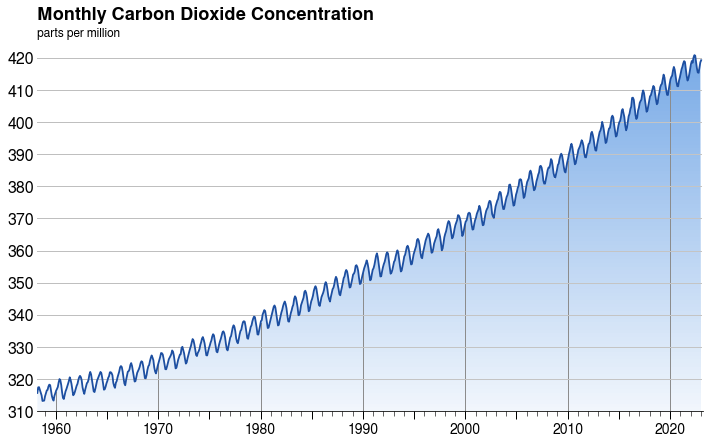

In [28]:
fig = plt.figure()

ax = fig.add_subplot()

# ------------------------
# Add gradiant under curve
# ------------------------

# For gradient max, use last date of data rather than current date
xmax_gradient = max(date_all)

area_color = '#73a7e6'

gradient_fill(date_spline_all, co2_spline_all, fill_color=area_color, xmin=xmin, xmax=xmax_gradient,
              ymin=ymin, ymax=ymax, ax=ax, alpha_bottom=0.1, alpha=1.0)


# -------------
# Plot the data
# -------------

ax.plot(date_all, co2_all, '-', color='#1d4fa1', linewidth=1.8, zorder=10)

# -------------------
# Set plot properties
# -------------------
set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)


# ---------------------------------
# Add horizontal and vertical lines
# ---------------------------------

z_order = 5
x_max = max(date_all)
add_sight_lines(ax, date_all, co2_all, xmin, x_max, ymin, ymax, z_order)

# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)


# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.73
ypos = 0.18

#add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig)


plt.show()